In [1]:
from scripts.viz_utils import *
from scipy import stats
import processing.scales as scales

data = pd.read_csv('../data/data_scales.csv', index_col='ResponseId')
plots_path = '../plots/main_effect'

tia_scales = scales.tia_scales
scale_titles = scales.scale_titles

def format_dict(dict):
    string = ''
    for key, value in dict.items():
        if hasattr(value, '__iter__'):
            string += f'{key}: '
            for item in value:
                string += f'{item:.2f}, '
            string = string[:-2] # remove last comma
            string += '\n'
        else:
            string += f'{key}: {value:.2f}\n'
    return string

In [2]:
# remove "TiA - " from scale names
for (key, value) in scale_titles.items():
    if key[:3] == 'tia':
        value = value[6:]

### Overview

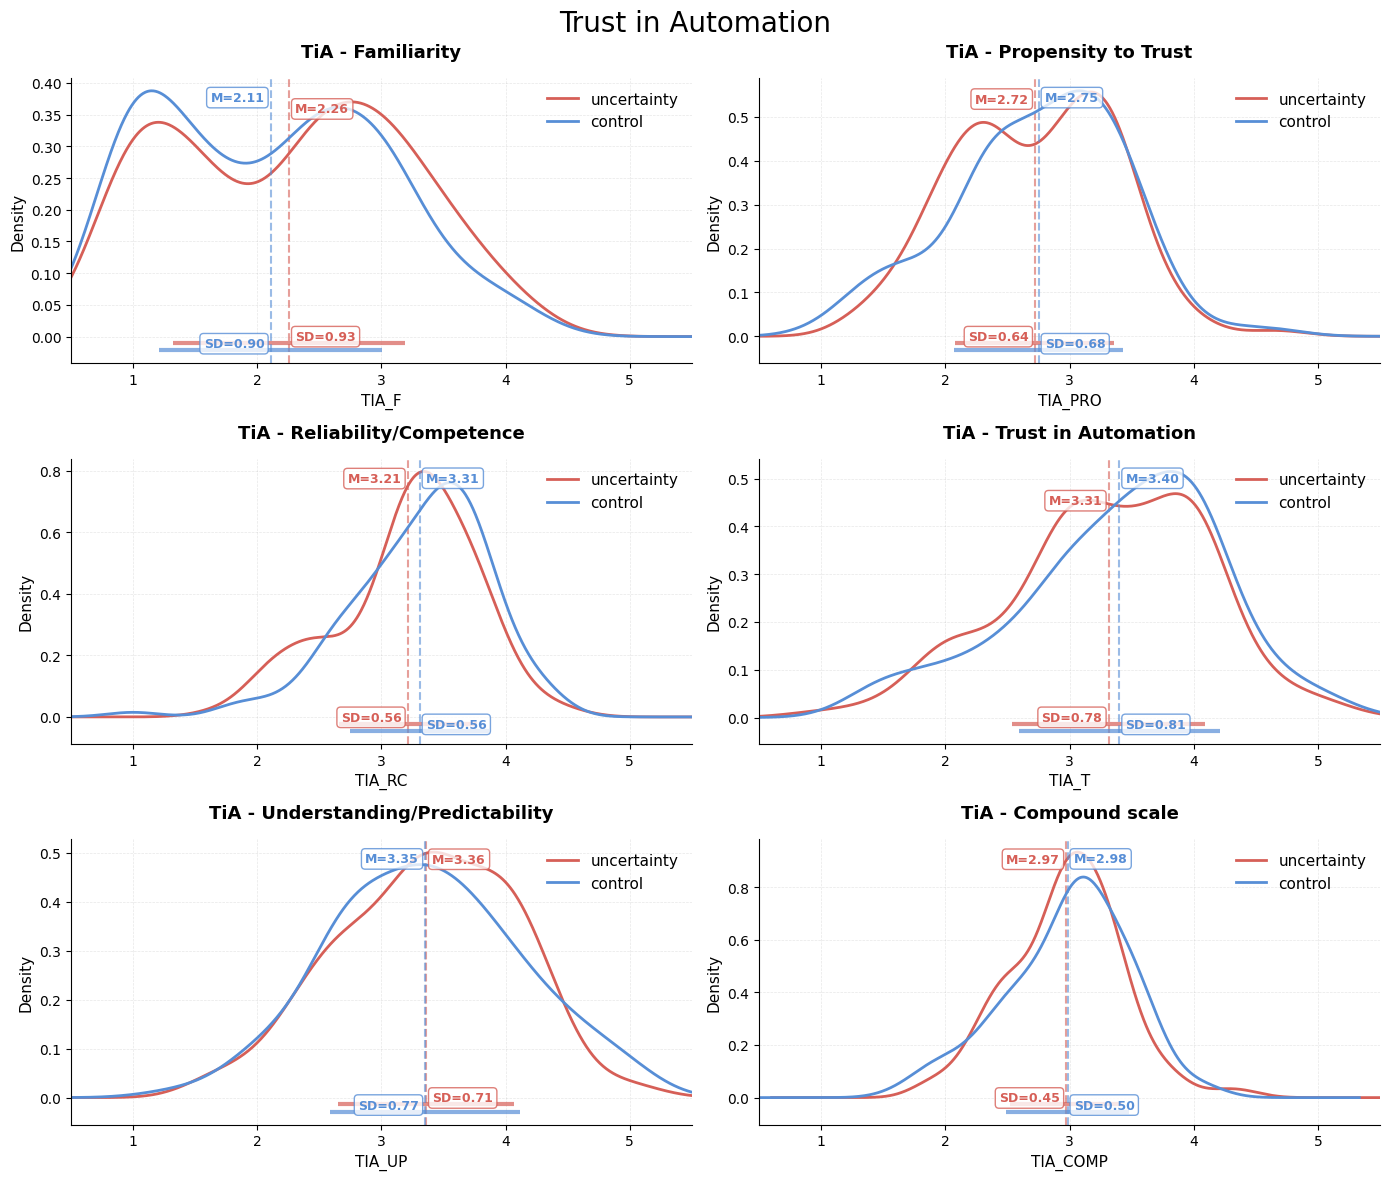

In [3]:
fig, axes = create_figure_grid(len(tia_scales), ncols=2, figsize=(14, 12))

for idx, scale in enumerate(tia_scales):
    plot_likert_distribution(data, scale, title=scale_titles[scale],
                             group_by='stimulus_group', ax=axes[idx],
                             show_stats=True,
                             show_correlation=False,
                             show_bars=False, show_kde=True)

fig.suptitle("Trust in Automation", fontsize=20)

plt.tight_layout()
plt.savefig(f'{plots_path}/main_effect_overview.png', transparent=True)
plt.show()

In [4]:
STANDARDIZED = False

# switch to using standardized z-score data
if STANDARDIZED:
    # standardize scores
    data_zscore = data[tia_scales].copy()

    for col in data_zscore.columns:
        data_zscore[col] = (data_zscore[col] - data_zscore[col].mean()) / data_zscore[col].std()

    # append stimulus group
    data_zscore['stimulus_group'] = data['stimulus_group'].copy()


    data = data_zscore

    data # show data to check

### Analysis

In [5]:
# sample size
N = [0, 0]
N[0] = len(data[data['stimulus_group'] == 0])
N[1] = len(data[data['stimulus_group'] == 1])

print(f'total participants:\tN = {len(data)}\n'
      f'\tuncertainty:\tN = {N[0]}\n'
      f'\tcontrol:\t\tN = {N[1]}\n')

total participants:	N = 255
	uncertainty:	N = 126
	control:		N = 129



In [6]:
# mean and standard deviation per scale
means = {}
stds = {}

for scale in tia_scales:
    means[scale] = [0, 0]
    means[scale][0] = np.mean(data[scale][data['stimulus_group'] == 0])
    means[scale][1] = np.mean(data[scale][data['stimulus_group'] == 1])

    stds[scale] = [0, 0]
    stds[scale][0] = np.std(data[scale][data['stimulus_group'] == 0])
    stds[scale][1] = np.std(data[scale][data['stimulus_group'] == 1])

print(f'means:\n{format_dict(means)}')
print(f'standard deviations:\n{format_dict(stds)}')

means:
tia_f: 2.11, 2.26
tia_pro: 2.75, 2.72
tia_rc: 3.31, 3.21
tia_t: 3.40, 3.31
tia_up: 3.35, 3.36
tia_comp: 2.98, 2.97

standard deviations:
tia_f: 0.90, 0.93
tia_pro: 0.68, 0.64
tia_rc: 0.56, 0.55
tia_t: 0.80, 0.78
tia_up: 0.76, 0.70
tia_comp: 0.49, 0.45



### Power Analysis: M_crit vs MDE

**MDE** (Minimum Detectable Effect, below):
- Includes both significance level (α) AND statistical power (1-β)
- Formula: `MDE = (t_α/2 + t_β) × SE`
- Answers: "What effect size can we detect with X% probability (power)?"

The MDE is always larger than M_crit because it accounts for the probability of detecting a true effect.

In [7]:
# Minimum Detectable Effect (MDE) per scale with explicit power
power = 0.80  # 80% power (standard)
beta = 1 - power
alpha = 0.05

MDE = {}  # minimum detectable effect
se = {}  # standard error

for scale in tia_scales:
    s1, s2 = stds[scale][0], stds[scale][1]
    n1, n2 = N[0], N[1]

    # standard error
    se[scale] = np.sqrt((s1**2 / n1) + (s2**2 / n2))

    # degrees of freedom (using Welch-Satterthwaite approximation for unequal variances)
    numerator = (s1**2/n1 + s2**2/n2)**2
    denominator = (s1**2/n1)**2/(n1-1) + (s2**2/n2)**2/(n2-1)
    df = numerator / denominator

    # Critical t-values
    t_alpha = stats.t.ppf(1 - alpha/2, df)  # for significance (two-tailed)
    t_beta = stats.t.ppf(1 - beta, df)      # for power

    # MDE = (t_α/2 + t_β) × SE
    MDE[scale] = (t_alpha + t_beta) * se[scale]

print(f'standard errors:\n{format_dict(se)}')
print(f'MDE:\n{format_dict(MDE)}')

standard errors:
tia_f: 0.11
tia_pro: 0.08
tia_rc: 0.07
tia_t: 0.10
tia_up: 0.09
tia_comp: 0.06

MDE:
tia_f: 0.32
tia_pro: 0.23
tia_rc: 0.20
tia_t: 0.28
tia_up: 0.26
tia_comp: 0.17




Non-Inferiority Test Results for 'TiA - Familiarity':
  Mean difference: M_diff = 0.149, SE = 0.114
  95% CI: [-0.076, 0.373]
  SESOI margin: -0.322
  z = 4.112, p < .001
  Result: Non-inferiority established (p < .001)


Non-Inferiority Test Results for 'TiA - Propensity to Trust':
  Mean difference: M_diff = -0.030, SE = 0.083
  95% CI: [-0.192, 0.131]
  SESOI margin: -0.232
  z = 2.444, p = .007
  Result: Non-inferiority established (p = .007)


Non-Inferiority Test Results for 'TiA - Reliability/Competence':
  Mean difference: M_diff = -0.098, SE = 0.069
  95% CI: [-0.234, 0.039]
  SESOI margin: -0.195
  z = 1.408, p = .080
  Result: Non-inferiority not established (p = .080)


Non-Inferiority Test Results for 'TiA - Trust in Automation':
  Mean difference: M_diff = -0.087, SE = 0.099
  95% CI: [-0.281, 0.107]
  SESOI margin: -0.278
  z = 1.935, p = .026
  Result: Non-inferiority not established (p = .026)


Non-Inferiority Test Results for 'TiA - Understanding/Predictability':
  

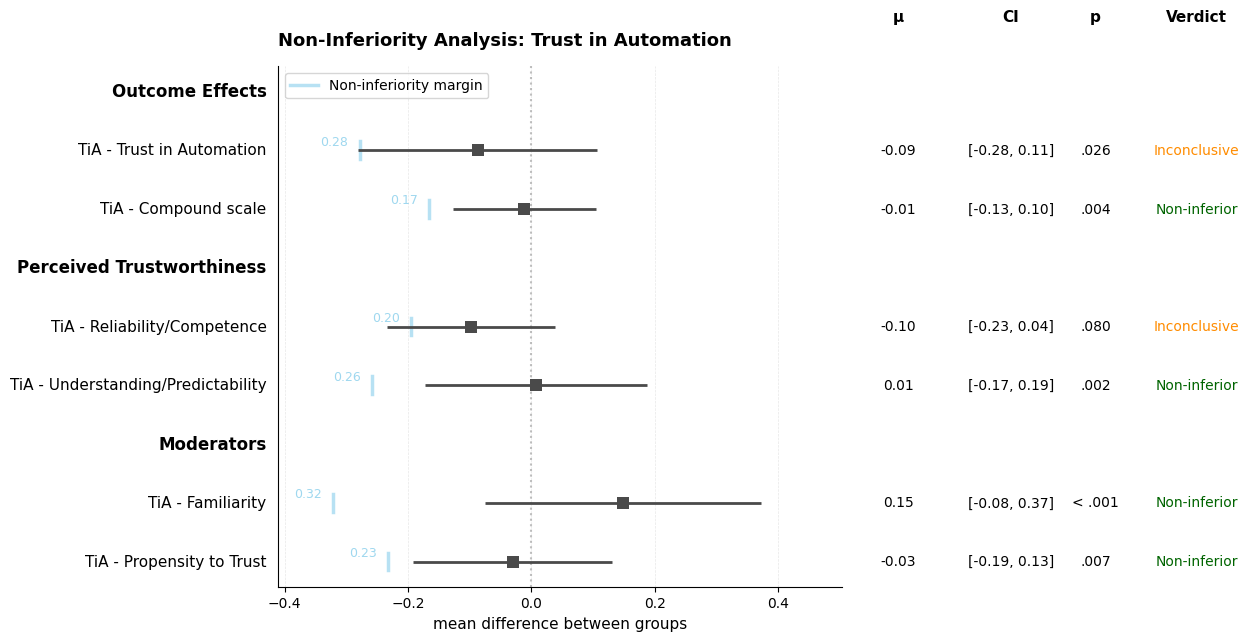

In [8]:
# perform test + plot
categories = {'Outcome Effects': ['tia_t', 'tia_comp'],
              'Perceived Trustworthiness': ['tia_rc', 'tia_up'],
              'Moderators': ['tia_f', 'tia_pro']}

fig, ax = plt.subplots(1, figsize=(12, 10))
plot_noninferiority_test(effect_size=[means[scale][1] - means[scale][0] for scale in tia_scales],
                         sesoi=[MDE[scale] for scale in tia_scales],
                         se=[se[scale] for scale in tia_scales],
                         alpha=alpha,
                         variable_names=tia_scales,
                         variable_labels=scale_titles,
                         title='Non-Inferiority Analysis: Trust in Automation',
                         xlabel='mean difference between groups',
                         categories=categories,
                         category_order=['Outcome Effects', 'Perceived Trustworthiness', 'Moderators'],
                         ax=ax)

plt.tight_layout()
plt.savefig(f'{plots_path}/main_effect_noninferiority.png', transparent=True)
plt.show()